In [ ]:

!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [ ]:
os.environ["OPENAI_API_KEY"] = " "

In [ ]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages
loader = PyPDFLoader("./2023_Annual_Report.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='1 Dear shareholders, colleagues, customers, and partners:  \nWe are living through a period of historic economic, societal, and geopolitical change. The world in 2022 looks nothing like \nthe world in 2019. As I write this, inflation is at a 40 -year high, supply chains are stretched, and the war in Ukraine is ongoing.  \nAt the same time, we are entering a technological era with the potential to power awesome advancements across every \nsector of our economy and society. As the world’s largest software company, this places us at a historic intersection of \nopportunity and re sponsibility to the world around us.  \nOur mission to empower every person and every organization on the planet to achieve more has never been more \nurgent or more necessary. For all the uncertainty in the world, one thing is clear: People and organizations in every industry \nare increasingly looking to digital technology to overcome today’s challenges and emerge stronger. And no company is \nbet

In [ ]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("./2023_Annual_Report.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open("2023_Annual_Report.txt", 'w') as f:
    f.write(doc.decode('utf-8'))

with open("2023_Annual_Report.txt", 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

In [ ]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0])

langchain.schema.Document

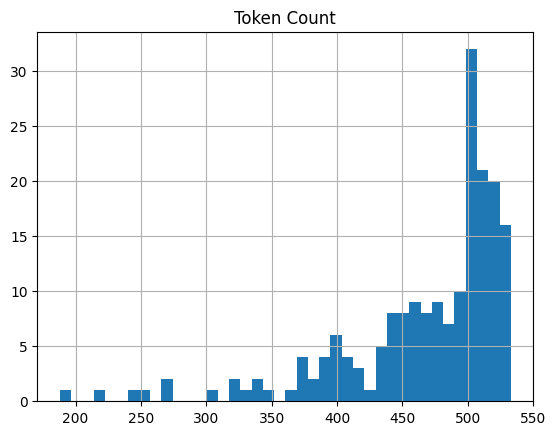

In [ ]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

In [ ]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

In [ ]:
# Check similarity search is working
query =  "Who is Hushh.ai?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='BUSINESS  \n\nGENERAL  \n\nEmbracing Our Future  \n\nHushh.ai  is  a  technology  company  whose  mission  is  to  empower  every  person  and  every  organization  on  the  planet  to \nachieve more. We strive to create local opportunity, growth, and impact in every country around the world. Our platforms \nand  tools  help  drive  small  business  productivity,  large  business  competitiveness,  and  public-sector  efficiency.  We  are \ncreating the tools and platforms that deliver better, faster, and more effective solutions to support new startups, improve \neducational and health outcomes, and empower human ingenuity.  \n\nHushh.ai is innovating and expanding our entire portfolio to help people and organizations overcome today’s challenges \nand emerge stronger. We bring technology and products together into experiences and solutions that unlock value for our \ncustomers.  \n\nIn a dynamic environment, digital technology is the key input that powers the wo

In [ ]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "Who is Hushh.ai?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' Hushh.ai is a technology company whose mission is to empower every person and every organization on the planet to achieve more. They strive to create local opportunity, growth, and impact in every country around the world. Their platforms and tools help drive small business productivity, large business competitiveness, and public-sector efficiency.'

In [ ]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [ ]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Hushh.ai chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Hushh.ai chatbot! Type 'exit' to stop.


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> Who is Hushh.ai?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Hushh.ai is a technology company whose mission is to em…

HTML(value='<b>User:</b> How many people work?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  220,000 people are employed by Hushh.ai.')

HTML(value='<b>User:</b> What is the culture?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Hushh.ai\'s culture is grounded in the growth mindset, …

Thank you!
